# Departamento de Polícia de Seattle
## Análise de dados relativo ao uso da força na cidade de Seattle

Aqui iremos explorar os dados disponibilizados pelo departamento de polícia de Seattle para extrair o máximo de informações relevantes.

Nesta primeira etapa iremos carregar as bibliotecas e os dados que usaremos nas nossas análises. Os dados serão também pré-processados para torna-los mais legíveis e facilitar o processo de sumarização das informações.

In [354]:
#encoding:utf-8
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt;

import geopandas as gpd;

In [355]:
# Carregando os dados
data = pd.read_csv('./data/use-of-force.csv', sep=",").set_index('ID');

In [356]:
# Carregando dados geograficos
precinctsGeo = gpd.read_file('./data/spd-precincts.geojson');
beatsGeo = gpd.read_file('./data/spd-beats.geojson');
## Criando o mapa dos setores a partir dos beats
#     Como não foi possível encontrar os dados geográficos dos setores
#     iremos produzi-lo a partir dos beats
#     o nome dos beats é o nome do setor concatenado com um número inteiro entre 1 e 3
sectors = [w[0] for w in beatsGeo['name']];
beatsGeo['sector'] = sectors;
sectorsGeo = beatsGeo.dissolve(by='sector');
sectorsGeo['name'] = [w[0] for w in sectorsGeo['name']];

In [357]:
# Tratar dados faltantes
# Dados faltantes ou não presentes na descrição dos dados serão associados
# a um valor padrão '-'
## Precinct faltantes ou ausentes => '-'
data['Precinct'] = data['Precinct'].fillna('-')
data['Precinct'] = data['Precinct'].str.replace('X','-');
## Setores faltantes ou ausentes => '-'
data['Sector'] = data['Sector'].str.replace('X','-');
data['Sector'] = data['Sector'].str.replace('99','-');
## Beats faltantes ou ausentes => '-'
data['Beat'] = data['Beat'].fillna('-');
data['Beat'] = data['Beat'].str.replace('99','-');
data['Beat'] = data['Beat'].str.replace('XX','-');
## Gênero e raça ausentes => '-'
data['Subject_Race'] = data['Subject_Race'].fillna('-');
data['Subject_Gender'] = data['Subject_Gender'].fillna('-');

# Análise geográfica dos dados
Aqui estudaremos como se dá o uso da força nas diferentes regiões da cidade. Esse estudo será feito em valores absoluto e relativo, como descreveremos em cada caso.

## Como é a distribuição do uso de força dentre as delegacias e os setores?
Os gráficos abaixo mostram o gráfico de calor formado pelo número de ocorrências em cada delegacia e em cada setor, respectivamente. Aqui podemos ver que o maior número de ocorrências está na delegacia **W** e nos setores **E** e **K**

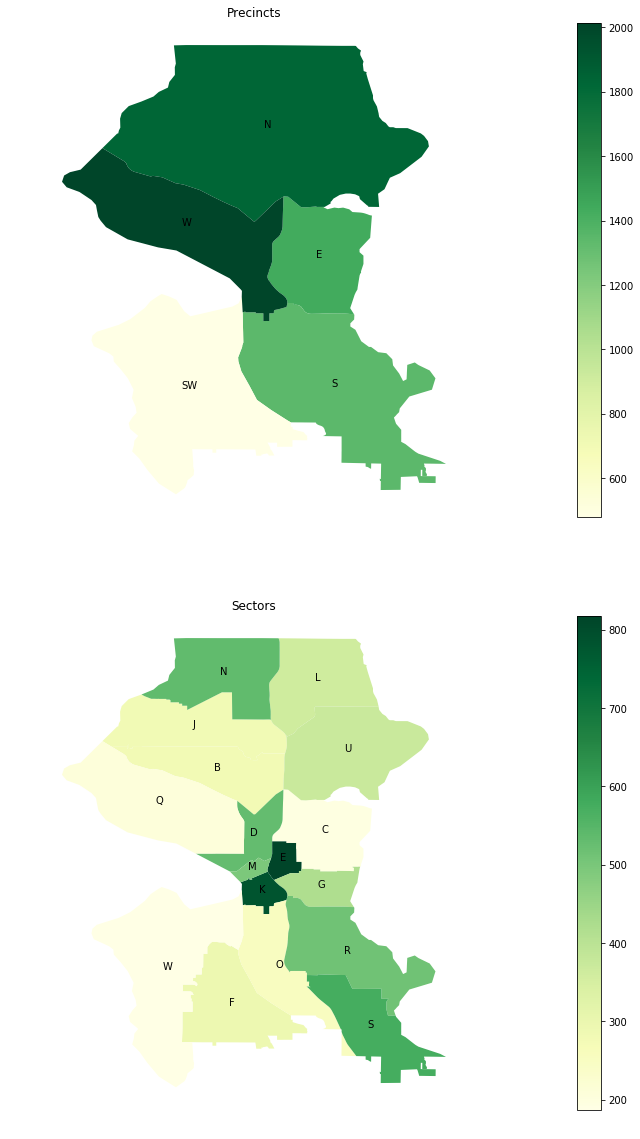

In [358]:
#Como as ocorrencias se distribuem nas delegacias e nos setores
pTotal = data['Precinct'].value_counts();
total = [];
for precName in precinctsGeo['name']:
    total.append(pTotal[precName]);
precinctsGeo['total'] = total;

sTotal = data['Sector'].value_counts();
total = [];
for secName in sectorsGeo['name']:
    total.append(sTotal[secName]);
sectorsGeo['total'] = total;

#Plots
fig, axes = plt.subplots(2, 1, figsize=(40, 20));
fig.subplots_adjust(hspace=0.2, wspace=0.1);

ax = precinctsGeo.plot(ax=axes.flat[0], column='total', cmap='YlGn', legend=True);
ax.set_title('Precincts');
ax.set_axis_off();
for idx, row in precinctsGeo.iterrows():
    ax.annotate(s=row['name'], xy=row['geometry'].centroid.coords[0],horizontalalignment='center');

ax = sectorsGeo.plot(ax=axes.flat[1], column='total', cmap='YlGn', legend=True);
ax.set_title('Sectors');
ax.set_axis_off();
for idx, row in sectorsGeo.iterrows():
    ax.annotate(s=row['name'], xy=row['geometry'].centroid.coords[0],horizontalalignment='center');

## Em cada setor, qual o *beat* com maior número de incidentes?

Deixando um pouco de lado a análise do número de ocorrências na cidade como um todo, focaremos agora na distribuição das ocorrências dentro dos setores. 

Para buscar mensurar o quanto cada beat contribui para o número de ocorrências do setor, construímos um mapa de calor guiado pelo número relativo de ocorrências no beat em relação ao setor.

**Atenção:** Os beats mais escuros são os que contribuem proporcionalmente mais para o número de ocorrências do seu setor, não necessariamente os que possuem mais registros de ocorrência.

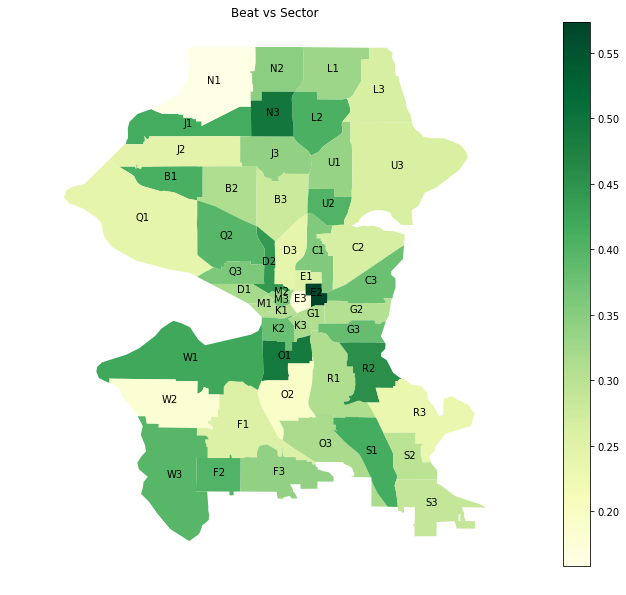

In [359]:
# Quanto um beat é "responsável" pelo resultado do seu setor?
bTotal = data['Beat'].value_counts();
total = [];
relSec = [];
for bName in beatsGeo['name']:
    total.append(bTotal[bName]);
    relSec.append(float(bTotal[bName])/sTotal[bName[0]]);
beatsGeo['total'] = total;
beatsGeo['relSec'] = relSec;

fig, axes = plt.subplots(figsize=(20, 10));
fig.subplots_adjust(hspace=0.2, wspace=0.1);

ax = beatsGeo.plot(ax=axes, column='relSec', cmap='YlGn', legend=True);
ax.set_title('Beat vs Sector');
ax.set_axis_off();
for idx, row in beatsGeo.iterrows():
    ax.annotate(s=row['name'], xy=row['geometry'].centroid.coords[0],horizontalalignment='center');

## Detalhando as ocorrências de um setor específico
Caso tenha interesse em aprofundar o estudo em um setor específico, modifique o valor da variável **S** na célula abaixo para ver um gráfico de pizza do setor.

No exemplo original o setor detalhado é o **E**, que no mapa de calor possui o beat **E2** bem escuro. No gráfico de pizza, a relação parte todo fica bem evidente, tornando mais clara a percepção de o quanto um beat é "maior" que o outro.

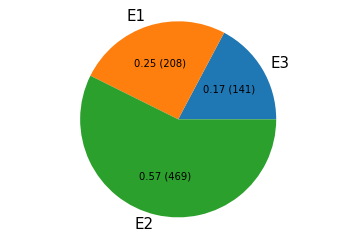

In [360]:
## Explora um setor específico

S = 'E'; # Setor a ser detalhado
v = beatsGeo[beatsGeo['sector']==S]['total'];
l = beatsGeo[beatsGeo['sector']==S]['name'];

fig1, ax1 = plt.subplots()
ax1.pie(v, labels = l, autopct=lambda p: '%.2f (%.0f)' % (p / 100, p * np.sum(v) / 100));
ax1.axis('equal');
plt.show();

## Ranking dos setores segundo o percentual de incidentes "Level 2" em relação ao total de incidentes do respectivo setor

A análise baseada no número de ocorrências pode esconder informações importantes. Aqui estudaremos o percentual de ocorrências "graves" de cada setor.

O gráfico de calor abaixo mostra essa relação.

**Atenção:** a cor mais escura indica que o percentual de ocorrências level 2 daquele setor é maior.Nada podemos afirmar sobre o número absoluto. Por exemplo, o setor **E** é o que possui a maior quantidade de ocorrências level 2, mas não é o mais escuro pois devido ao grande número total de ocorrências, a razão fica menor que a de outros setores.

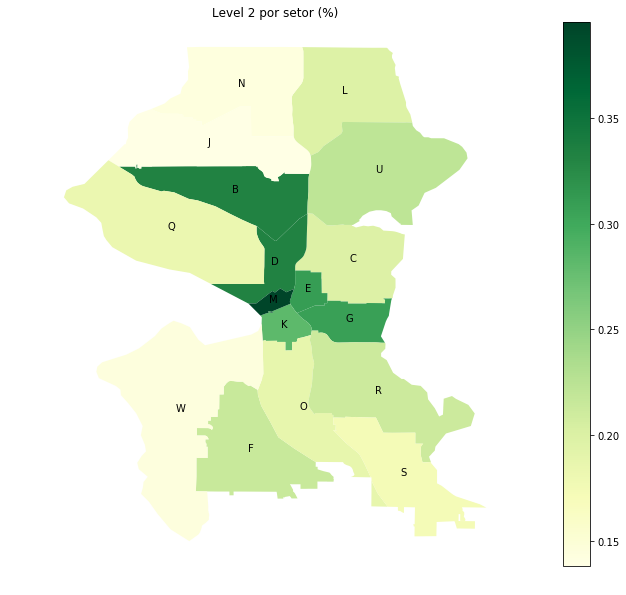

In [361]:
# Em cada setor, qual a proporção entre level 2 vs total do setor?

sTotal = data['Sector'].value_counts();
level2 = [];
for secName in sectorsGeo['name']:
    v = data[data['Sector']==secName]['Incident_Type'].value_counts()['Level 2 - Use of Force'];    
    level2.append(float(v)/sTotal[secName]);
sectorsGeo['level2'] = level2;

fig, axes = plt.subplots(1, 1, figsize=(20, 10));
ax = sectorsGeo.plot(ax=axes, column='level2', cmap='YlGn', legend=True);
ax.set_title('Level 2 por setor (%)');
ax.set_axis_off();
for idx, row in sectorsGeo.iterrows():
    ax.annotate(s=row['name'], xy=row['geometry'].centroid.coords[0],horizontalalignment='center');

No gráfico acima, podemos ver claramente que os setores **B**, **D**, **E**, **G**, **K** e **M** apresentam um percentual de ocorrências level 2 maior que os demais, sendo o setor **M** o com o pior resultado. Tais setores estão em uma faixa continua de território, o que pode ser um indicador importante na tomada de decisões em relação a isso.

## Ocorrências vs razão

No gráfico a seguir procuramos explorar a relação entre o número total de ocorrências de cada setor, divididas por tipo, e a proporção de ocorrências level 2.

Colocamos os setores ordenados pela quantidade total de ocorrências e deixamos as ocorrências level 2 na base do gráfico, para facilitar as comparações.

Além disso, acrescentamos uma linha que marca a proporção de ocorrências level 2 de cada setor. Se as ocorrências level 2 se distribuicem igualmente em todos os setores, teriamos aqui uma linha horizontal, o que não aconteceu. Marcamos também uma linha tracejada vermelha com a média do percentual de ocorrências level 2. Ela nos permite notar que os setores que estão acima da média são exatamente **B**, **D**, **E**, **G**, **K** e **M**, os mesmos que identificamos no mapa de calor.

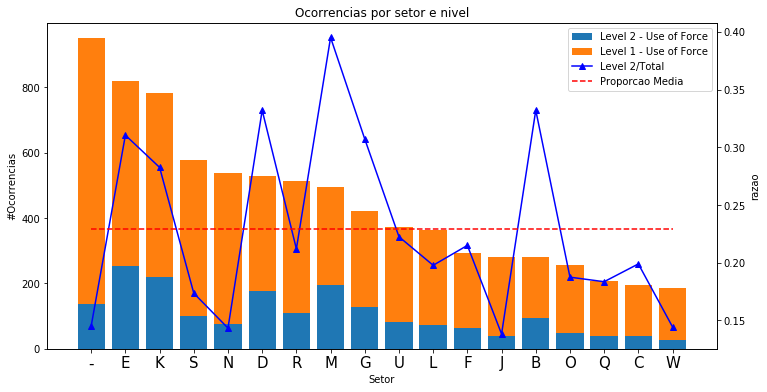

In [362]:
l1Values = [];
l2Values = [];
for sName in sTotal.keys():
    v = data[data['Sector']==sName]['Incident_Type'].value_counts();
    l1Values.append(v['Level 1 - Use of Force']);
    l2Values.append(v['Level 2 - Use of Force']);

fig, ax1 = plt.subplots(figsize=(12, 6));

ind = np.arange(len(l1Values));
p1 = ax1.bar(ind, l2Values);
p2 = ax1.bar(ind, l1Values, bottom=l2Values);
ax1.set_ylabel('#Ocorrencias');
ax1.set_title('Ocorrencias por setor e nivel');
plt.xticks(ind, sTotal.keys());
plt.xlabel('Setor');

ax2 = ax1.twinx()
razao = l2Values/sTotal;
p3 = ax2.plot(ind, razao, 'b^-');
ax2.set_ylabel('razao');

p4 = ax2.plot(ind, np.ones(len(ind))*np.mean(razao), 'r--');

plt.legend((p1[0], p2[0], p3[0], p4[0]), ('Level 2 - Use of Force', 'Level 1 - Use of Force', 'Level 2/Total', 'Proporcao Media'));

plt.show()

# Distribuição dos incidentes no tempo

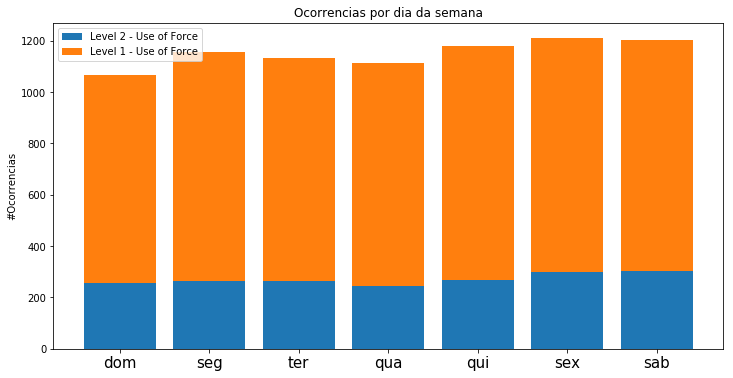

In [389]:
data['w_day'] = [pd.to_datetime(D, yearfirst=True).weekday() for D in data['Occured_date_time']];

l1Values = [];
l2Values = [];
for wd in [0,1,2,3,4,5,6]:
    v = data[data['w_day']==wd]['Incident_Type'].value_counts();
    l1Values.append(v['Level 1 - Use of Force']);
    l2Values.append(v['Level 2 - Use of Force']);

fig, ax1 = plt.subplots(figsize=(12, 6));

ind = np.arange(len(l1Values));
p1 = ax1.bar(ind, l2Values);
p2 = ax1.bar(ind, l1Values, bottom=l2Values);
ax1.set_ylabel('#Ocorrencias');
ax1.set_title('Ocorrencias por dia da semana');
wDayName = ['dom','seg','ter','qua','qui','sex','sab'];
plt.xticks(ind, wDayName);

plt.legend((p1[0], p2[0]), ('Level 2 - Use of Force', 'Level 1 - Use of Force'));
#plt.xlabel('Dia da semana');

## Descrição do experimento

A seguir veremos figuras que ilustram a distribuição dos atributos categóricos do dataset. Cada atributo será visualizado de três formas:
    1. distribuição geral (em todo o dataset)
    2. distribuição dos dados das amostras aprovadas
    3. distribuição dos dados das amostras recusadas    
    
Os atributos com poucas categorias serão visualizados na forma de um gráfico de pizza onde a fatia indica a quantidade de amostras com cada valor. Os atributos com muitas categorias serão vistos na forma de histograma, uma vez que o gráfico de pizza ficaria com a visualização bem comprometida. O histograma não é exatamente a melhor forma, uma vez que não há uma relação de proximidade entre os valores, mas ao menos nos permitirá enxergar de forma mais clara a distribuição dos dados.

A resposta foi rotulada como 0 para <b>aprovada</b> e 1 para <b>recusada</b>

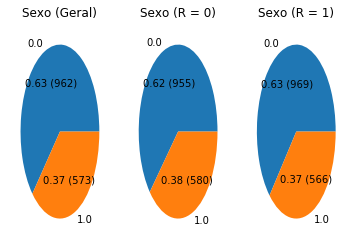

In [3]:
plt.subplot(131)
plt.title('Sexo (Geral)')
d = 0
values = []
for v in np.unique(data.iloc[:,d]):
    values.append(np.sum(data.iloc[:,d] == v))
p = plt.pie(values, labels = np.unique(data.iloc[:,d]), autopct=lambda p: '%.2f (%.0f)' % (p / 100, p * N / 100))

plt.subplot(132)
plt.title('Sexo (R = 0)')
v0 = data.iloc[(data.iloc[:,-1] == 0).values, d]
values = []
for v in np.unique(data.iloc[:,d]):
    values.append(np.sum(v0 == v))
p = plt.pie(values, labels = np.unique(data.iloc[:,d]), autopct=lambda p: '%.2f (%.0f)' % (p / 100, p * N / 100))

plt.subplot(133)
plt.title('Sexo (R = 1)')
v0 = data.iloc[(data.iloc[:,-1] == 1).values, d]
values = []
for v in np.unique(data.iloc[:,d]):
    values.append(np.sum(v0 == v))
p = plt.pie(values, labels = np.unique(data.iloc[:,d]), autopct=lambda p: '%.2f (%.0f)' % (p / 100, p * N / 100))

#valores distintos: 291


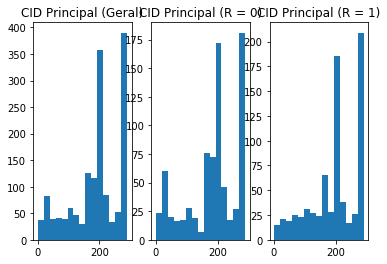

In [4]:
print('#valores distintos: %d' % (np.unique(data.iloc[:,1]).size))
d = 1

plt.subplot(131)
plt.title('CID Principal (Geral)')
h = plt.hist(data.iloc[:,d], bins = 15)

plt.subplot(132)
plt.title('CID Principal (R = 0)')
v0 = data.iloc[(data.iloc[:,-1] == 0).values, d]
h = plt.hist(v0, bins = 15)

plt.subplot(133)
plt.title('CID Principal (R = 1)')
v0 = data.iloc[(data.iloc[:,-1] == 1).values, d]
h = plt.hist(v0, bins = 15)

#valores distintos: 291


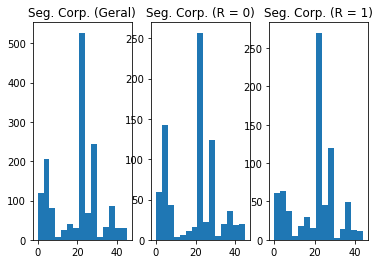

In [5]:
print('#valores distintos: %d' % (np.unique(data.iloc[:,1]).size))
d = 2

plt.subplot(131)
plt.title('Seg. Corp. (Geral)')
h = plt.hist(data.iloc[:,d], bins = 15)

plt.subplot(132)
plt.title('Seg. Corp. (R = 0)')
v0 = data.iloc[(data.iloc[:,-1] == 0).values, d]
h = plt.hist(v0, bins = 15)

plt.subplot(133)
plt.title('Seg. Corp. (R = 1)')
v0 = data.iloc[(data.iloc[:,-1] == 1).values, d]
h = plt.hist(v0, bins = 15)

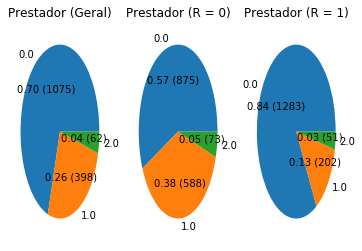

In [6]:
plt.subplot(131)
plt.title('Prestador (Geral)')
d = 3
values = []
for v in np.unique(data.iloc[:,d]):
    values.append(np.sum(data.iloc[:,d] == v))
p = plt.pie(values, labels = np.unique(data.iloc[:,d]), autopct=lambda p: '%.2f (%.0f)' % (p / 100, p * N / 100))

plt.subplot(132)
plt.title('Prestador (R = 0)')
v0 = data.iloc[(data.iloc[:,-1] == 0).values, d]
values = []
for v in np.unique(data.iloc[:,d]):
    values.append(np.sum(v0 == v))
p = plt.pie(values, labels = np.unique(data.iloc[:,d]), autopct=lambda p: '%.2f (%.0f)' % (p / 100, p * N / 100))

plt.subplot(133)
plt.title('Prestador (R = 1)')
v0 = data.iloc[(data.iloc[:,-1] == 1).values, d]
values = []
for v in np.unique(data.iloc[:,d]):
    values.append(np.sum(v0 == v))
p = plt.pie(values, labels = np.unique(data.iloc[:,d]), autopct=lambda p: '%.2f (%.0f)' % (p / 100, p * N / 100))

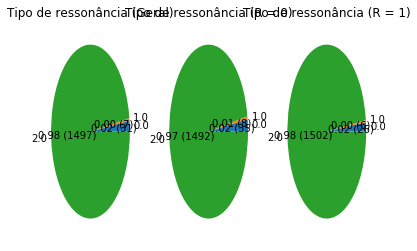

In [7]:
plt.subplot(131)
plt.title('Tipo de ressonância (Geral)')
d = 4
values = []
for v in np.unique(data.iloc[:,d]):
    values.append(np.sum(data.iloc[:,d] == v))
p = plt.pie(values, labels = np.unique(data.iloc[:,d]), autopct=lambda p: '%.2f (%.0f)' % (p / 100, p * N / 100))

plt.subplot(132)
plt.title('Tipo de ressonância (R = 0)')
v0 = data.iloc[(data.iloc[:,-1] == 0).values, d]
values = []
for v in np.unique(data.iloc[:,d]):
    values.append(np.sum(v0 == v))
p = plt.pie(values, labels = np.unique(data.iloc[:,d]), autopct=lambda p: '%.2f (%.0f)' % (p / 100, p * N / 100))

plt.subplot(133)
plt.title('Tipo de ressonância (R = 1)')
v0 = data.iloc[(data.iloc[:,-1] == 1).values, d]
values = []
for v in np.unique(data.iloc[:,d]):
    values.append(np.sum(v0 == v))
p = plt.pie(values, labels = np.unique(data.iloc[:,d]), autopct=lambda p: '%.2f (%.0f)' % (p / 100, p * N / 100))

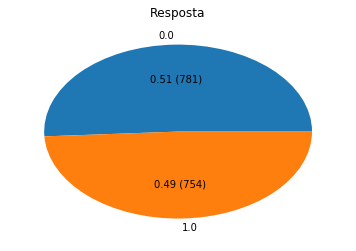

In [8]:
plt.title('Resposta')
values = []
for v in np.unique(data.iloc[:,-1]):
    values.append(np.sum(data.iloc[:,-1] == v))
p = plt.pie(values, labels = np.unique(data.iloc[:,-1]), autopct=lambda p: '%.2f (%.0f)' % (p / 100, p * N / 100))

# Análise dos resultados

Exceto pelo atributo <b>prestador</b>, todos os outros não possuem uma relação muito evidente com a aprovação ou não da solicitação.
Em relação ao prestador, verificamos que a CEMISE é responsável por 70% das solicitações, mas corresponde a apenas 57% dos aprovados e, por outro lado, sobe para 84% quando analisamos apenas as solicitações recusadas. Isso pode indicar que este prestador tem uma tendencia maior de solicitar o exame de forma desnescessária.